In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import build_2d_grid, train_parameters, evaluation, tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph

# colormap
cmap = plt.get_cmap('plasma')

# Planning:
- get test examples to run, handle ind point limitations
- get real world dataset example to run

### BUGS:

- nans occur for too many ind points (in exp gradient)
- m and S values go to infinity if inducing_point_res >= 9

(solved?)

- implemented logdet for kl div, added stabilizer


### TODOS:
- clean code into functions
- Check T region definition (currently limits of inducing points)
- Add inducing point location optimization

- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

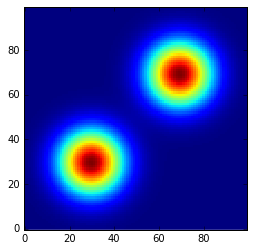

In [3]:
res = 100
Tlims = np.array([[0., 10.], [0., 10.]])

X = build_2d_grid(Tlims, res)
vals = double_blob(X).reshape(res,res)

plt.imshow(vals, interpolation='none', origin='lower')
plt.show()

In [4]:
samples, _, _, _, _, _ = get_scp_samples(double_blob, Tlims, 10)

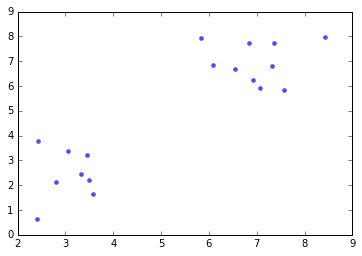

In [5]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

#### Evaluation with learned alphas and increasing number of inducing points

Begin training
ind point number:  2
alphas:  [ 1.20090127  1.22240007]
gamma:  0.131542


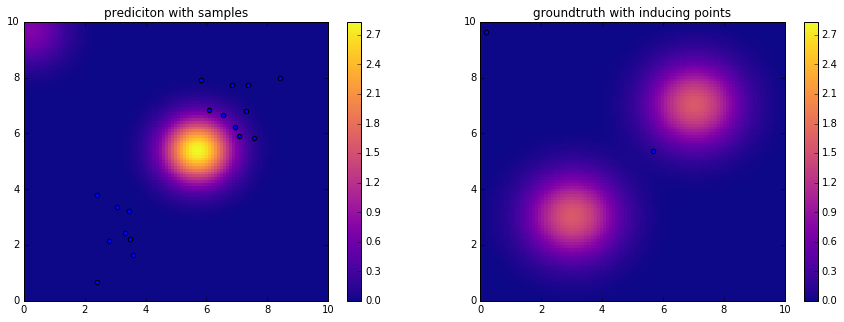

In [6]:
## ######## ##
# PARAMETERS #
## ######## ##

tf.logging.set_verbosity(tf.logging.DEBUG)

# general options
train_hyperparameters    = False
optimize_inducing_points = True
ind_point_nums           = [2]

# gradient descent optionss
max_iterations = 10000
learning_rate  = 0.00001

# hyperparameter initialization:
alphas_init = [1.20090127,  1.22240007]
gamma_init  = 0.131542

# tensorboard options:
logdir = 'logs/2d_blob'

# build_evaluation_grid
eval_res = 100
eval_grid = build_2d_grid(Tlims, eval_res)

for n_ind, i in enumerate(ind_point_nums): 
        
    m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt = train_parameters(samples, i, Tlims, 
                                                                              optimize_inducing_points=optimize_inducing_points, 
                                                                              train_hyperparameters=train_hyperparameters,
                                                                              learning_rate=learning_rate,
                                                                              max_iterations=max_iterations,
                                                                              log_dir=logdir,
                                                                              alphas_init=alphas_init,
                                                                              gamma_init=gamma_init
                                                                             )
    lam_vals = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt, eval_grid)

    #plots
    fig = plt.figure(figsize=(15, 5)) 
    max_value = np.max([np.max(vals), np.max(lam_vals)])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

    print("ind point number: ",i)
    print("alphas: ",alphas_opt)
    print("gamma: ",gamma_opt)
    
    xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], eval_res), np.linspace(Tlims[1,0], Tlims[1,1], eval_res))
    
    ax0 = plt.subplot(1,2,1)
    im = ax0.pcolormesh(xx, yy, lam_vals.reshape(eval_res,eval_res), cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('prediciton with samples')
    ax0.scatter(samples[:,0], samples[:,1])
    plt.xlim(Tlims[0,0], Tlims[0,1])
    plt.ylim(Tlims[1,0], Tlims[1,1])

    ax1 = plt.subplot(1,2, 2)
    im1 = ax1.pcolormesh(xx, yy, vals, cmap=cmap,norm=norm)
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('groundtruth with inducing points')
    ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
    plt.xlim(Tlims[0,0], Tlims[0,1])
    plt.ylim(Tlims[1,0], Tlims[1,1])
    #plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
    plt.show()